Heteroscedastic Implementation of Deep Ensembles

no adversarial Training is used

Most of the code inspired by:
https://github.com/cameronccohen/deep-ensembles/blob/master/Tutorial.ipynb

Necessary imports

In [1]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
import numpy as np
import optuna
from optuna.trial import TrialState
import random

# define the device for the setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    sys.path.append(r'C:\Users\Surface\Masterarbeit')
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':  # desktop name
    sys.path.append(r'C:\Users\test\Masterarbeit')
    
else:
    raise ValueError("Unbekannter Computername: " + os.environ['COMPUTERNAME'])

import NN_model
import data_prep


In [2]:
SEED = 42

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

Load, Transform and Split the data

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test, feature_names = data_prep.load_tranform_and_split_data('C1_V01_delta_kan', split_ratio=(0.6, 0.2, 0.2))

# convert the data to PyTorch tensors
# and add an extra dimension for the target variable
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float() 
y_train_tensor = torch.from_numpy(y_train).float().reshape(-1,1) # Add extra dimension for compatibility
y_val_tensor = torch.from_numpy(y_val).float().reshape(-1,1)
y_test_tensor = torch.from_numpy(y_test).float().reshape(-1,1)
print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)
print(feature_names)
print(y_train_tensor.shape, y_val_tensor.shape, y_test_tensor.shape)

torch.Size([31206, 37]) torch.Size([10402, 37]) torch.Size([10403, 37])
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')
torch.Size([31206, 1]) torch.Size([10402, 1]) torch.Size([10403, 1])


Optuna Hyperparameter Search

In [4]:
def objective(trial):
    
    set_seed(SEED)  # Set the seed for reproducibility
    # hyperparameter for sampling with Optuna
    n_layer = trial.suggest_int("n_layer", 3, 7)  # number of hidden layers
    n_neurons = trial.suggest_int("n_neurons", 32, 512, step=32)  # number of neurons in each hidden layer
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)    # learning rate
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512]) 
    
    # decay factor for the number of neurons in each layer
    # e.g. if n_neurons = 256 and n_layer = 3
    # then the hidden_dims will be [256, 128, 64]
    #decay = trial.suggest_float('decay', 0.5, 0.7, step = 0.1)
    # # this creates a list of integers representing the number of neurons in each hidden layer
    #hidden_dims = [int(n_neurons * decay**i) for i in range(n_layer)]
    hidden_dims = []
    #hidden_dims = [n_neurons]*n_layer  # all layers have the same number of neurons
    # for i in range(n_layer):
    #     n_units = trial.suggest_int(f"n_units_l{i}", 32, 512, step=32)
    #     hidden_dims.append(n_units)

    # for bottleneckstructure
    bottleneck_neurons = trial.suggest_int("bottleneck_neurons", 32, n_neurons//2, step=32)
    half = n_layer // 2

    for i in range(n_layer):
        if i <= half:
            units = int(n_neurons - (n_neurons - bottleneck_neurons) * (i / half))
        else:
            units = int(bottleneck_neurons + (n_neurons - bottleneck_neurons) * ((i - half) / half))
        units = max(units, 32)  # Ensure at least 32 units
        hidden_dims.append(units)

    print(f"Hidden dimensions: {hidden_dims}")
        
    # generate the model with the sampled hyperparameters
    # and move it to the device (GPU or CPU)
    model = NN_model.Custom_NN_Model(
        input_dim=X_train_tensor.shape[1],
        hidden_dims=hidden_dims,
        output_dim=1,
        do_rate=0,
        loss_type = 'heteroscedastic'
    ).to(device)

    # AdamW optimizer, where weight decay does not accumulate in the momentum nor variance.
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = lr, weight_decay=0.0001)  

    # DataLoader for batching the data
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # integrate early stopping
    patience = 20  # number of epochs with no improvement after which training will be stopped
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # training the model
    for epoch in range(epochs):
        model.train()
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)  # Move data to the device (GPU or CPU)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            
            loss = NN_model.heteroscedastic_loss(model, X_batch, y_batch)
            loss.backward()
            optimizer.step()
            
        # validation loss calculation after each epoch
        model.eval()
        with torch.no_grad():
            val_loss = NN_model.heteroscedastic_loss(model, X_val_tensor, y_val_tensor)
            
        trial.report(val_loss, step=epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            #print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}, Best Val Loss: {best_val_loss:.4f}")
                break
    
    return best_val_loss


In [5]:
print(f"Using device: {device}")

# number of epochs for training
epochs = 500

# create a study object for Optuna
study = optuna.create_study(
    #study_name="MC_Dropout_Optuna_Network_architecture",
    #storage="sqlite:///mc_dropout_study.db",                    # Use SQLite database to store the
    #load_if_exists=True,                                        # load the study if it already exists
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed = SEED),                       #TPE (Tree-structured Parzen Estimator) sampler by default
    pruner=optuna.pruners.MedianPruner(        
        n_startup_trials=20,                                    # Number of trials to run before pruning starts
        n_warmup_steps=10                                        # Number of warmup steps before pruning starts)
    )
)

# move the tensors to the device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# optimize the objective function with Optuna
# timeout=None means no time limit for the optimization, all trials will be run
study.optimize(objective, n_trials=100, timeout=None, n_jobs=1, show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-08-22 08:28:18,198] A new study created in memory with name: no-name-1e539fdc-7898-492d-bafb-0ccee696fa22


Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden dimensions: [512, 368, 224, 368]
Early stopping at epoch 120, Best Val Loss: 1.5032
[I 2025-08-22 08:32:27,724] Trial 0 finished with value: 1.5031867027282715 and parameters: {'n_layer': 4, 'n_neurons': 512, 'lr': 0.0029106359131330704, 'batch_size': 64, 'bottleneck_neurons': 224}. Best is trial 0 with value: 1.5031867027282715.
Hidden dimensions: [384, 277, 170, 64, 170, 277]
Early stopping at epoch 139, Best Val Loss: 1.4633
[I 2025-08-22 08:37:48,090] Trial 1 finished with value: 1.4633198976516724 and parameters: {'n_layer': 6, 'n_neurons': 384, 'lr': 0.00010994335574766199, 'batch_size': 64, 'bottleneck_neurons': 64}. Best is trial 1 with value: 1.4633198976516724.
Hidden dimensions: [288, 176, 64, 176]


c:\Users\test\Masterarbeit\.venv\Lib\site-packages\optuna\distributions.py:702: UserWarning: The distribution is specified by [32, 144] and step=32, but the range is not divisible by `step`. It will be replaced by [32, 128].
  warnings.warn(


Early stopping at epoch 200, Best Val Loss: 1.4605
[I 2025-08-22 08:41:26,583] Trial 2 finished with value: 1.4604922533035278 and parameters: {'n_layer': 4, 'n_neurons': 288, 'lr': 0.0007309539835912913, 'batch_size': 128, 'bottleneck_neurons': 64}. Best is trial 2 with value: 1.4604922533035278.
Hidden dimensions: [416, 240, 64, 240, 416]


c:\Users\test\Masterarbeit\.venv\Lib\site-packages\optuna\distributions.py:702: UserWarning: The distribution is specified by [32, 208] and step=32, but the range is not divisible by `step`. It will be replaced by [32, 192].
  warnings.warn(


Early stopping at epoch 214, Best Val Loss: 1.4985
[I 2025-08-22 08:43:11,476] Trial 3 finished with value: 1.4984952211380005 and parameters: {'n_layer': 5, 'n_neurons': 416, 'lr': 0.00025081156860452336, 'batch_size': 512, 'bottleneck_neurons': 64}. Best is trial 2 with value: 1.4604922533035278.
Hidden dimensions: [512, 128, 512]
Early stopping at epoch 22, Best Val Loss: 72.8148
[I 2025-08-22 08:43:51,585] Trial 4 finished with value: 72.81483459472656 and parameters: {'n_layer': 3, 'n_neurons': 512, 'lr': 0.00853618986286683, 'batch_size': 64, 'bottleneck_neurons': 128}. Best is trial 2 with value: 1.4604922533035278.
Hidden dimensions: [256, 96, 256]
Early stopping at epoch 214, Best Val Loss: 1.4652
[I 2025-08-22 08:50:19,188] Trial 5 finished with value: 1.4652137756347656 and parameters: {'n_layer': 3, 'n_neurons': 256, 'lr': 0.00011715937392307068, 'batch_size': 64, 'bottleneck_neurons': 96}. Best is trial 2 with value: 1.4604922533035278.
Hidden dimensions: [96, 64, 32, 64, 

c:\Users\test\Masterarbeit\.venv\Lib\site-packages\optuna\distributions.py:702: UserWarning: The distribution is specified by [32, 48] and step=32, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


Early stopping at epoch 225, Best Val Loss: 1.5141
[I 2025-08-22 08:54:39,941] Trial 6 finished with value: 1.5141342878341675 and parameters: {'n_layer': 5, 'n_neurons': 96, 'lr': 0.00869299151113955, 'batch_size': 128, 'bottleneck_neurons': 32}. Best is trial 2 with value: 1.4604922533035278.
Hidden dimensions: [64, 53, 42, 32, 42, 53, 64]
Early stopping at epoch 256, Best Val Loss: 1.5587
[I 2025-08-22 08:58:03,884] Trial 7 finished with value: 1.558671236038208 and parameters: {'n_layer': 7, 'n_neurons': 64, 'lr': 0.0002465844721448739, 'batch_size': 256, 'bottleneck_neurons': 32}. Best is trial 2 with value: 1.4604922533035278.
Hidden dimensions: [192, 160, 128, 96, 128, 160, 192]
Early stopping at epoch 217, Best Val Loss: 1.4794
[I 2025-08-22 09:00:57,192] Trial 8 finished with value: 1.4794107675552368 and parameters: {'n_layer': 7, 'n_neurons': 192, 'lr': 0.0003646439558980723, 'batch_size': 256, 'bottleneck_neurons': 96}. Best is trial 2 with value: 1.4604922533035278.
Hidden

c:\Users\test\Masterarbeit\.venv\Lib\site-packages\optuna\distributions.py:702: UserWarning: The distribution is specified by [32, 176] and step=32, but the range is not divisible by `step`. It will be replaced by [32, 160].
  warnings.warn(


Early stopping at epoch 71, Best Val Loss: 1.5581
[I 2025-08-22 09:13:09,852] Trial 11 finished with value: 1.5581464767456055 and parameters: {'n_layer': 6, 'n_neurons': 352, 'lr': 0.0007291323910342046, 'batch_size': 128, 'bottleneck_neurons': 64}. Best is trial 2 with value: 1.4604922533035278.
Hidden dimensions: [416, 298, 181, 64, 181, 298]
Early stopping at epoch 98, Best Val Loss: 1.6065
[I 2025-08-22 09:14:00,833] Trial 12 finished with value: 1.6065337657928467 and parameters: {'n_layer': 6, 'n_neurons': 416, 'lr': 0.001720313260628461, 'batch_size': 512, 'bottleneck_neurons': 64}. Best is trial 2 with value: 1.4604922533035278.
Hidden dimensions: [224, 144, 64, 144]


c:\Users\test\Masterarbeit\.venv\Lib\site-packages\optuna\distributions.py:702: UserWarning: The distribution is specified by [32, 112] and step=32, but the range is not divisible by `step`. It will be replaced by [32, 96].
  warnings.warn(


Early stopping at epoch 33, Best Val Loss: 1.7617
[I 2025-08-22 09:14:37,207] Trial 13 finished with value: 1.7616703510284424 and parameters: {'n_layer': 4, 'n_neurons': 224, 'lr': 0.0034296673213264376, 'batch_size': 128, 'bottleneck_neurons': 64}. Best is trial 2 with value: 1.4604922533035278.
Hidden dimensions: [384, 256, 128, 256, 384]
Early stopping at epoch 112, Best Val Loss: 1.4770
[I 2025-08-22 09:18:38,109] Trial 14 finished with value: 1.476952314376831 and parameters: {'n_layer': 5, 'n_neurons': 384, 'lr': 0.0004897008670209763, 'batch_size': 64, 'bottleneck_neurons': 128}. Best is trial 2 with value: 1.4604922533035278.
Hidden dimensions: [288, 224, 160, 96, 160, 224]
Early stopping at epoch 146, Best Val Loss: 1.4878
[I 2025-08-22 09:21:41,769] Trial 15 finished with value: 1.4877614974975586 and parameters: {'n_layer': 6, 'n_neurons': 288, 'lr': 0.00018333630119671276, 'batch_size': 128, 'bottleneck_neurons': 96}. Best is trial 2 with value: 1.4604922533035278.
Hidden 

c:\Users\test\Masterarbeit\.venv\Lib\site-packages\optuna\distributions.py:702: UserWarning: The distribution is specified by [32, 80] and step=32, but the range is not divisible by `step`. It will be replaced by [32, 64].
  warnings.warn(


Early stopping at epoch 193, Best Val Loss: 1.5180
[I 2025-08-22 09:23:10,676] Trial 16 finished with value: 1.5180127620697021 and parameters: {'n_layer': 4, 'n_neurons': 160, 'lr': 0.0008285490401283153, 'batch_size': 512, 'bottleneck_neurons': 64}. Best is trial 2 with value: 1.4604922533035278.
Hidden dimensions: [448, 320, 192, 320, 448]
Early stopping at epoch 161, Best Val Loss: 1.4857
[I 2025-08-22 09:25:09,250] Trial 17 finished with value: 1.4857045412063599 and parameters: {'n_layer': 5, 'n_neurons': 448, 'lr': 0.0015622977192083275, 'batch_size': 256, 'bottleneck_neurons': 192}. Best is trial 2 with value: 1.4604922533035278.
Hidden dimensions: [320, 32, 320]
Early stopping at epoch 151, Best Val Loss: 1.5089
[I 2025-08-22 09:27:43,042] Trial 18 finished with value: 1.508895754814148 and parameters: {'n_layer': 3, 'n_neurons': 320, 'lr': 0.00038909593109766387, 'batch_size': 128, 'bottleneck_neurons': 32}. Best is trial 2 with value: 1.4604922533035278.
Hidden dimensions: [

c:\Users\test\Masterarbeit\.venv\Lib\site-packages\optuna\distributions.py:702: UserWarning: The distribution is specified by [32, 240] and step=32, but the range is not divisible by `step`. It will be replaced by [32, 224].
  warnings.warn(
c:\Users\test\Masterarbeit\.venv\Lib\site-packages\optuna\pruners\_percentile.py:21: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(values)


[I 2025-08-22 09:52:05,300] Trial 30 pruned. 
Hidden dimensions: [256, 96, 256]
[I 2025-08-22 09:52:42,749] Trial 31 pruned. 
Hidden dimensions: [320, 208, 96, 208]
Early stopping at epoch 160, Best Val Loss: 1.4512
[I 2025-08-22 09:57:59,234] Trial 32 finished with value: 1.4511967897415161 and parameters: {'n_layer': 4, 'n_neurons': 320, 'lr': 0.00029958613091621094, 'batch_size': 64, 'bottleneck_neurons': 96}. Best is trial 32 with value: 1.4511967897415161.
Hidden dimensions: [320, 224, 128, 224]
Early stopping at epoch 147, Best Val Loss: 1.4608
[I 2025-08-22 10:03:13,180] Trial 33 finished with value: 1.4608169794082642 and parameters: {'n_layer': 4, 'n_neurons': 320, 'lr': 0.0002754554649580518, 'batch_size': 64, 'bottleneck_neurons': 128}. Best is trial 32 with value: 1.4511967897415161.
Hidden dimensions: [320, 224, 128, 224]
Early stopping at epoch 104, Best Val Loss: 1.4797
[I 2025-08-22 10:06:50,792] Trial 34 finished with value: 1.4796783924102783 and parameters: {'n_layer

ValueError: The `low` value must be smaller than or equal to the `high` value (low=32, high=16).

Create an Ensemble

In [6]:
# number of networks
n = 5
nets_ops = []
for i in range(n):
    net = NN_model.Custom_NN_Model(input_dim=X_train.shape[1], hidden_dims=[416, 208, 104, 52], output_dim=1, do_rate=0, loss_type='heteroscedastic')  # Create model instance and move to device
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0008, weight_decay=0.0001)  # Create optimizer
    nets_ops.append((net, optimizer))
    
print(nets_ops[0])  # Print the first model to check if it was created correctly

(Custom_NN_Model(
  (hidden_layers): Sequential(
    (0): Linear(in_features=37, out_features=416, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=416, out_features=208, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=208, out_features=104, bias=True)
    (7): ReLU()
    (8): Dropout(p=0, inplace=False)
    (9): Linear(in_features=104, out_features=52, bias=True)
    (10): ReLU()
    (11): Dropout(p=0, inplace=False)
  )
  (mean_layer): Linear(in_features=52, out_features=1, bias=True)
  (var_layer): Linear(in_features=52, out_features=1, bias=True)
), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0008
    maximize: False
    weight_decay: 0.0001
))


Method for Training the Ensembles

In [7]:
def train_model(net, optimizer, X_train, y_train, X_val, y_val, X_test,  batch_size=64, n_epochs=1000, patience=20, device = 'cpu'):
    
    # DataLoader for batching the data
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
        
    # Early Stopping values
    best_val_loss = np.inf
    epochs_no_improve = 0
    loss_history = []
    val_loss_history = []
    net.to(device)  # Move model to device
    for epoch in range(n_epochs):
        net.train()
        batch_losses = []
        for X_batch, y_batch in train_loader:
            #print(y_batch.shape)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            #print(net(X_batch)[0].shape)
            optimizer.zero_grad()
            loss = NN_model.heteroscedastic_loss(net, X_batch, y_batch) # does a forward pass and computes the loss  
           
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        loss_history.append(loss.item())
            
        # calculate validation loss
        net.eval()                            # Set model to evaluation mode
        with torch.no_grad():

            # Forward pass
            val_loss = NN_model.heteroscedastic_loss(net, X_val, y_val)
                
            val_loss_history.append(val_loss.item())
            
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = net.state_dict()
            print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {np.mean(batch_losses):.4f}, Val Loss: {val_loss.item():.4f}, Best Val Loss: {best_val_loss:.4f}")
            
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}, Best Val Loss: {best_val_loss:.4f}")
                net.load_state_dict(best_model_state)
                break    
            
    
    outputs_mean, outputs_log_var = net(X_test)
    outputs_mean = outputs_mean.detach().cpu().numpy()
    outputs_log_var = outputs_log_var.detach().cpu().numpy()
    
    return loss_history, val_loss_history, outputs_mean, outputs_log_var

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

outputs_mean = []
outputs_log_var = []
loss_histories = []
val_loss_histories = []
for net, ops in nets_ops:
    loss_history, val_loss_history, output_mean, output_log_var = train_model(net = net, optimizer = ops,
                                                                              X_train = X_train_tensor, y_train = y_train_tensor, 
                                                                              X_val = X_val_tensor, y_val = y_val_tensor,
                                                                              X_test = X_test_tensor,
                                                                              device = device)
    outputs_mean.append(output_mean)
    outputs_log_var.append(np.exp(output_log_var))

    loss_histories.append(loss_history)
    val_loss_histories.append(val_loss_history)

outputs_mean = np.array(outputs_mean)
outputs_log_var = np.array(outputs_log_var)

Epoch 1/1000, Train Loss: 128.3221, Val Loss: 5.1736, Best Val Loss: 5.1736
Epoch 2/1000, Train Loss: 3.3988, Val Loss: 2.7004, Best Val Loss: 2.7004
Epoch 3/1000, Train Loss: 2.4964, Val Loss: 2.3336, Best Val Loss: 2.3336
Epoch 4/1000, Train Loss: 2.2359, Val Loss: 2.1263, Best Val Loss: 2.1263
Epoch 5/1000, Train Loss: 2.0732, Val Loss: 2.0053, Best Val Loss: 2.0053
Epoch 6/1000, Train Loss: 1.9655, Val Loss: 1.9904, Best Val Loss: 1.9904
Epoch 7/1000, Train Loss: 1.9096, Val Loss: 1.8812, Best Val Loss: 1.8812
Epoch 9/1000, Train Loss: 1.8550, Val Loss: 1.8624, Best Val Loss: 1.8624
Epoch 11/1000, Train Loss: 1.8007, Val Loss: 1.7908, Best Val Loss: 1.7908
Epoch 13/1000, Train Loss: 1.7861, Val Loss: 1.7880, Best Val Loss: 1.7880
Epoch 15/1000, Train Loss: 1.7714, Val Loss: 1.7476, Best Val Loss: 1.7476
Epoch 17/1000, Train Loss: 1.7415, Val Loss: 1.7320, Best Val Loss: 1.7320
Epoch 22/1000, Train Loss: 1.7386, Val Loss: 1.7163, Best Val Loss: 1.7163
Epoch 23/1000, Train Loss: 1.70

Epistemic Variance: 1.221653
Aleatoric Variance: 8.656825
first ten aleatoric variances: [[186.06862  ]
 [  4.550502 ]
 [  4.8950815]
 [  4.6239185]
 [  6.9970107]
 [  4.9024796]
 [  6.9684777]
 [  4.2720995]
 [  2.9985342]
 [  5.0316625]] shape: (10403, 1)
first ten epistemic variances: [[6.113467  ]
 [1.0089623 ]
 [2.2162814 ]
 [0.4678925 ]
 [0.2629622 ]
 [0.37850308]
 [0.5496969 ]
 [1.0238079 ]
 [0.08411603]
 [0.9692194 ]] shape: (10403, 1)
 first ten total standard deviations: [[13.862975 ]
 [ 2.3578515]
 [ 2.666714 ]
 [ 2.2565043]
 [ 2.6944337]
 [ 2.298039 ]
 [ 2.741929 ]
 [ 2.3012838]
 [ 1.7557478]
 [ 2.4496696]] shape: (10403, 1)
Total Standard Deviation: 2.897564 
 y_test std: 7.556901931762695
torch.Size([10403, 1]) (10403, 1)
R² on Test Data: 0.849
Shape of de_lower_bound: (10403,), de_upper_bound: (10403,)
Number of true values within the confidence interval: 10075 out of 10403
Coverage: 96.85%


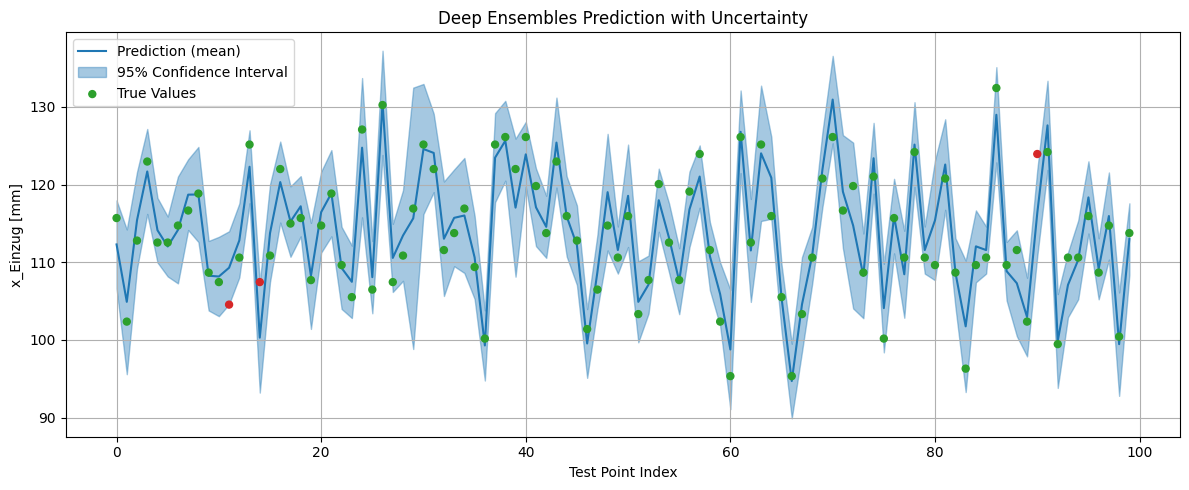

In [9]:
#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_test), num_points, replace=False)
random_indices.sort()

# Calculate the mean and standard deviation of the predictions on the test data
mean_test_pred_heteroscedastic = np.mean(outputs_mean, axis = 0)

# Calculate epistemic
epistemic_var_heteroscedastic = np.var(outputs_mean, axis=0)
print(f"Epistemic Variance: {epistemic_var_heteroscedastic.mean():.6f}")

# Calculate aleatoric variance (heteroscedastic)
aleatoric_var_heteroscedastic = np.mean(outputs_log_var, axis=0)
print(f"Aleatoric Variance: {aleatoric_var_heteroscedastic.mean():.6f}")

# Calculate total standard deviation
total_std_heteroscedastic = np.sqrt(epistemic_var_heteroscedastic + aleatoric_var_heteroscedastic)
print(f"first ten aleatoric variances: {aleatoric_var_heteroscedastic[:10]} shape: {aleatoric_var_heteroscedastic.shape}")
print(f"first ten epistemic variances: {epistemic_var_heteroscedastic[:10]} shape: {epistemic_var_heteroscedastic.shape}")
print(f" first ten total standard deviations: {total_std_heteroscedastic[:10]} shape: {total_std_heteroscedastic.shape}")
print(f"Total Standard Deviation: {total_std_heteroscedastic.mean():.6f} ")

print(f' y_test std: {y_test_tensor.std().item()}')
print(y_test_tensor.shape, mean_test_pred_heteroscedastic.shape)
# Calculate R² score for the test data
r2_test = r2_score(y_test_tensor.cpu().squeeze(), mean_test_pred_heteroscedastic)
print(f"R² on Test Data: {r2_test:.3f}")

# Assign descriptive variable names for Deep Ensembles mean and standard deviation
de_mean = mean_test_pred_heteroscedastic  # Predicted mean for each test point
de_std = total_std_heteroscedastic   # Predicted standard deviation for uncertainty

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
de_lower_bound = (de_mean - 2 * de_std).reshape(-1)  # Ensure it is a 1D array
de_upper_bound = (de_mean+ 2 * de_std).reshape(-1)  # Ensure it is a 1D array

print(f"Shape of de_lower_bound: {de_lower_bound.shape}, de_upper_bound: {de_upper_bound.shape}")

# calculate the coverage of the confidence interval
in_interval = (y_test >= de_lower_bound) & (y_test <= de_upper_bound)
# number of true
counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= de_lower_bound[random_indices]) & (y_test[random_indices] <= de_upper_bound[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)  # Create an index axis for plotting

# Plot the predicted mean
plt.plot(x_axis, de_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, de_lower_bound[random_indices], de_upper_bound[random_indices], alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')

# Scatter plot of true values with color-coded points based on interval inclusion
plt.scatter(x_axis, y_test_tensor[random_indices].cpu().flatten(), label="True Values", c=colors, s=25, zorder=3)

# Final plot settings
plt.title("Deep Ensembles Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()